In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import pandas as pd

# create spark session
spark = (
    SparkSession.builder
    .appName("nyc-jobs-analysis")
    .config("spark.sql.shuffle.partitions", "200")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("WARN")

### Read Data

In [3]:
df = spark.read.csv(
    "/dataset/nyc-jobs.csv",
    header=True,
    inferSchema=True
)
df.printSchema()
print("Total records:", df.count())

root
 |-- Job ID: integer (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: integer (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: double (nullable = true)
 |-- Salary Range To: double (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply: string (nullable = true)
 |-- Hours/Shift: string (nullable = true)
 |-- Work Locat

### Feature Engineering

In [4]:
def feature_engineering(df: DataFrame) -> DataFrame:
    df = df.withColumn("Salary Range From", col("Salary Range From").cast("double"))\
           .withColumn("Salary Range To", col("Salary Range To").cast("double"))

    df = df.withColumn("avg_salary", round((col("Salary Range From") + col("Salary Range To"))/2,2))
    df = df.withColumn("process_date", to_timestamp("Process Date", "yyyy-MM-dd'T'HH:mm:ss.SSS"))
    df = df.withColumn("process_year", year("process_date"))

    def edu_map(edu_str):
        if edu_str is None:
            return 0
        edu_str = edu_str.lower()
        if "phd" in edu_str or "doctor" in edu_str:
            return 5
        elif "master" in edu_str:
            return 4
        elif "bachelor" in edu_str:
            return 3
        elif "associate" in edu_str:
            return 2
        elif "high school" in edu_str or "diploma" in edu_str:
            return 1
        else:
            return 0

    edu_udf = udf(edu_map, IntegerType())
    df = df.withColumn("edu_level", edu_udf(col("Minimum Qual Requirements")))

    return df

df = feature_engineering(df)
df.printSchema()

root
 |-- Job ID: integer (nullable = true)
 |-- Agency: string (nullable = true)
 |-- Posting Type: string (nullable = true)
 |-- # Of Positions: integer (nullable = true)
 |-- Business Title: string (nullable = true)
 |-- Civil Service Title: string (nullable = true)
 |-- Title Code No: string (nullable = true)
 |-- Level: string (nullable = true)
 |-- Job Category: string (nullable = true)
 |-- Full-Time/Part-Time indicator: string (nullable = true)
 |-- Salary Range From: double (nullable = true)
 |-- Salary Range To: double (nullable = true)
 |-- Salary Frequency: string (nullable = true)
 |-- Work Location: string (nullable = true)
 |-- Division/Work Unit: string (nullable = true)
 |-- Job Description: string (nullable = true)
 |-- Minimum Qual Requirements: string (nullable = true)
 |-- Preferred Skills: string (nullable = true)
 |-- Additional Information: string (nullable = true)
 |-- To Apply: string (nullable = true)
 |-- Hours/Shift: string (nullable = true)
 |-- Work Locat

### Utility Function: Write CSV

In [5]:
def write_csv(df: DataFrame, path: str, mode: str = "overwrite", n_partitions: int = 1) -> None:
    df.repartition(n_partitions).write.mode(mode).option("header", True).csv(path)
    print(f"Data successfully written to {path}")

### KPI Functions

In [6]:
# Number of job postings per category
def get_number_of_job_postings_per_category(df: DataFrame, n: int) -> DataFrame:
    return df.groupBy("Job Category").agg(sum("# Of Positions").alias("total_job_postings"))\
             .orderBy("total_job_postings", ascending=False).limit(n)

# Salary distribution per category
def get_salary_distribution_per_category(df: DataFrame) -> DataFrame:
    df = df.withColumn("avg_salary", coalesce(col("avg_salary"), lit(0)))
    return df.groupBy("Job Category").agg(
        round(min("avg_salary"),2).alias("min_salary"),
        round(max("avg_salary"),2).alias("max_salary"),
        round(avg("avg_salary"),2).alias("avg_salary")
    ).orderBy("avg_salary", ascending=False)

# Highest salary per agency
def get_salary_distribution_per_agency(df: DataFrame) -> DataFrame:
    window = Window.partitionBy("Agency").orderBy(col("Salary Range To").desc())
    df_rank = df.select("Agency","Salary Range To","Business Title").withColumn("rank", row_number().over(window))\
                 .filter(col("rank") == 1).drop("rank")
    return df_rank

# Average salary per agency last 2 years
def get_salary_per_agency_last2_years(df: DataFrame) -> DataFrame:
    df_last2 = df.filter(col("process_date") >= date_sub(current_date(), 365*2))
    return df_last2.groupBy("Agency").agg(round(avg("avg_salary"),2).alias("avg_salary"))\
                   .orderBy("avg_salary", ascending=False)

# Highest paid skills
def get_highest_paid_skill(df: DataFrame, top_n: int) -> DataFrame:
    return df.select("Salary Range To","Business Title").distinct().orderBy(col("Salary Range To").desc()).limit(top_n)

### KPI Computation & Save

Data successfully written to /data_engineering_takehome1/jupyter/output/number_of_job_postings_per_category
+-----------------------------------------+------------------+
|Job Category                             |total_job_postings|
+-----------------------------------------+------------------+
|Public Safety, Inspections, & Enforcement|1407              |
|Building Operations & Maintenance        |1249              |
|Engineering, Architecture, & Planning    |762               |
|Legal Affairs                            |515               |
|Technology, Data & Innovation            |405               |
|Health                                   |358               |
|Administration & Human Resources         |330               |
|Finance, Accounting, & Procurement       |275               |
|Maintenance & Operations                 |212               |
|Policy, Research & Analysis              |200               |
+-----------------------------------------+------------------+



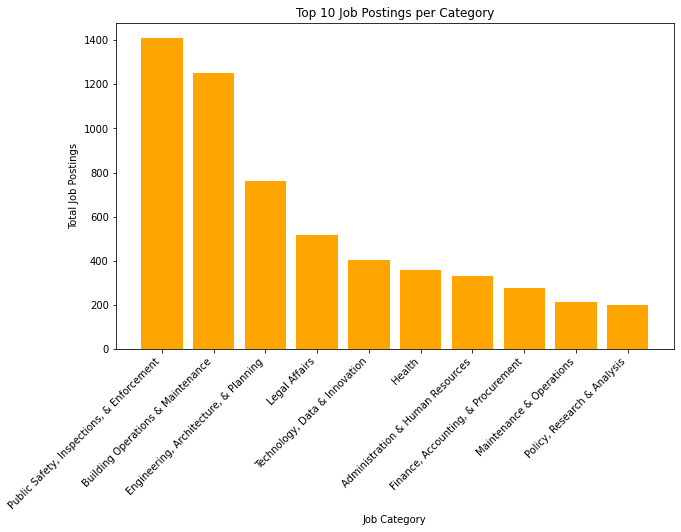

Data successfully written to /data_engineering_takehome1/jupyter/output/salary_distribution_per_category
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+----------+----------+
|Job Category                                                                                                                                                                                             |min_salary|max_salary|avg_salary|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------+----------+----------+
|Administration & Human Resources Finance, Accounting, & Procurement Building Operations & Maintenance                                                                                  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


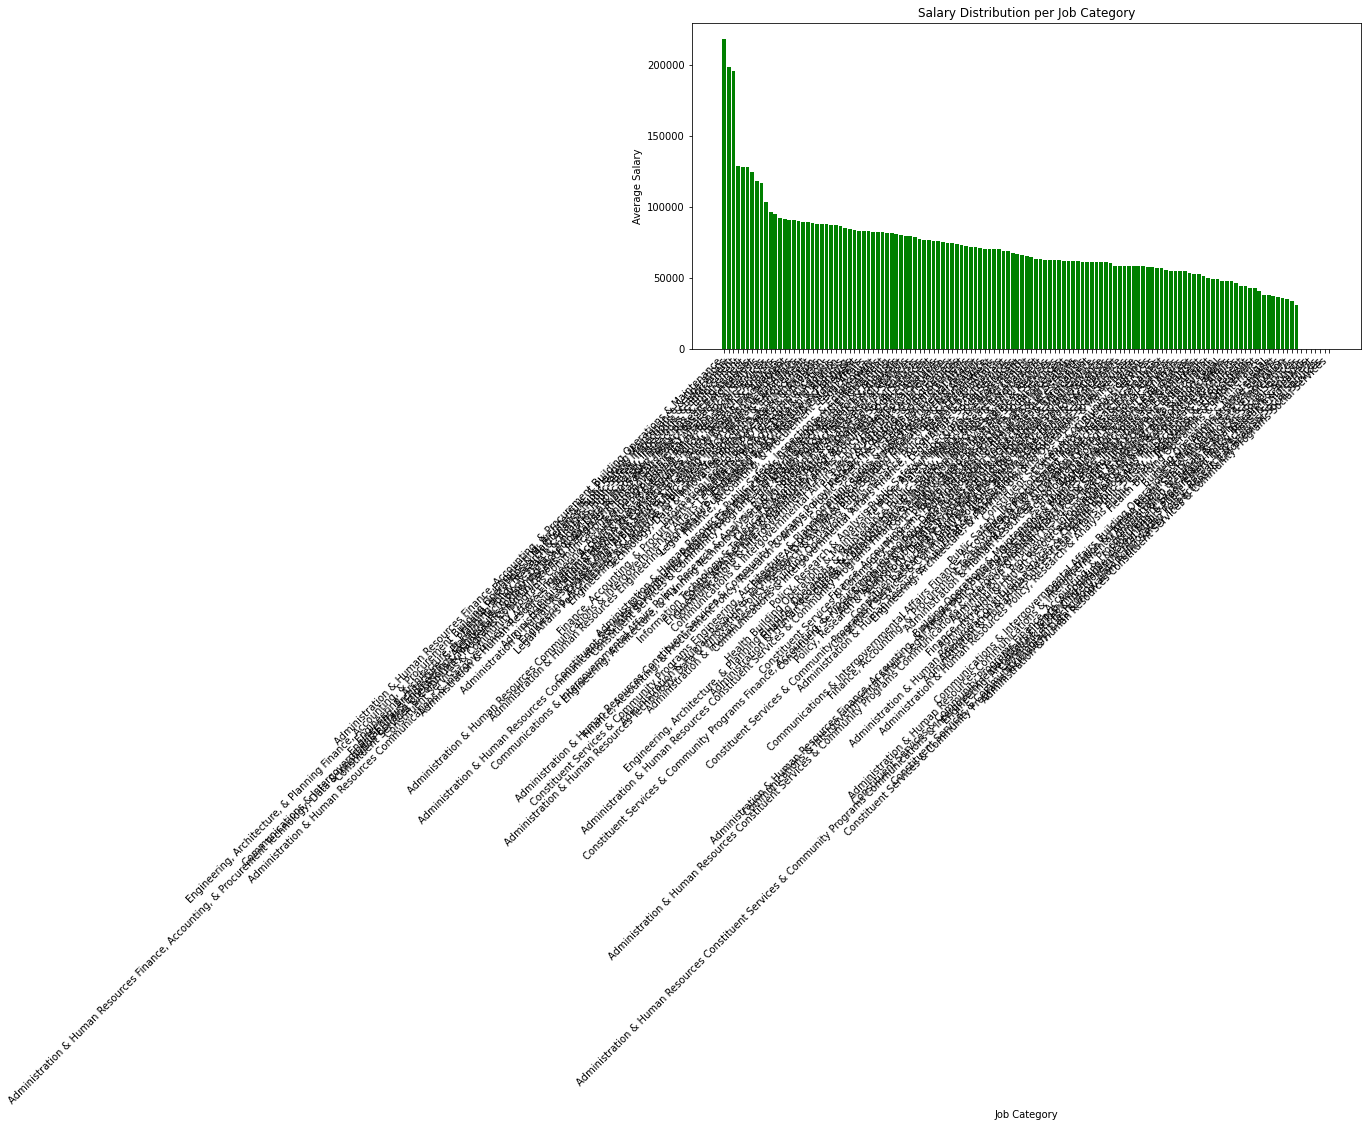

Data successfully written to /data_engineering_takehome1/jupyter/output/salary_distribution_per_agency
+------------------------------+---------------+----------------------------------------------------+
|Agency                        |Salary Range To|Business Title                                      |
+------------------------------+---------------+----------------------------------------------------+
|LANDMARKS PRESERVATION COMM   |64297.0        |LANDMARKS PRESERVATIONIST, PRESERVATION DEPT        |
|OFFICE OF COLLECTIVE BARGAININ|10.36          |COLLEGE AIDE - CLERICAL                             |
|FIRE DEPARTMENT               |144929.0       |Senior Enterprise Applications Integration Developer|
|ADMIN FOR CHILDREN'S SVCS     |156829.0       |Director of Technical  Support                      |
|MANHATTAN COMMUNITY BOARD #8  |19.0           |Community Assistant                                 |
|TAX COMMISSION                |90177.0        |CITY ASSESSOR                    

In [8]:
# 1️⃣ Number of job postings per category
job_postings_per_category_df = get_number_of_job_postings_per_category(df, 10)
write_csv(job_postings_per_category_df, '/data_engineering_takehome1/jupyter/output/number_of_job_postings_per_category')
job_postings_per_category_df.show(10, False)

# Visualization
job_cat_pd = job_postings_per_category_df.toPandas()
plt.figure(figsize=(10,6))
plt.bar(job_cat_pd['Job Category'], job_cat_pd['total_job_postings'], color='orange')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Job Category')
plt.ylabel('Total Job Postings')
plt.title('Top 10 Job Postings per Category')
plt.show()

# 2️⃣ Salary distribution per category
salary_distribution_per_category_df = get_salary_distribution_per_category(df)
write_csv(salary_distribution_per_category_df, '/data_engineering_takehome1/jupyter/output/salary_distribution_per_category')
salary_distribution_per_category_df.show(10, False)

# Visualization
salary_cat_pd = salary_distribution_per_category_df.toPandas()
salary_cat_pd['Job Category'] = salary_cat_pd['Job Category'].fillna('Unknown')
salary_cat_pd['Job Category'] = salary_cat_pd['Job Category'].astype(str)

plt.figure(figsize=(12,6))
plt.bar(salary_cat_pd['Job Category'], salary_cat_pd['avg_salary'], color='green')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Job Category')
plt.ylabel('Average Salary')
plt.title('Salary Distribution per Job Category')
plt.tight_layout()
plt.show()

# 3️⃣ Highest salary per agency
salary_distribution_per_agency_df = get_salary_distribution_per_agency(df)
write_csv(salary_distribution_per_agency_df, '/data_engineering_takehome1/jupyter/output/salary_distribution_per_agency')
salary_distribution_per_agency_df.show(10, False)

# 4️⃣ Average salary per agency last 2 years
salary_per_agency_last2_years_df = get_salary_per_agency_last2_years(df)
write_csv(salary_per_agency_last2_years_df, '/data_engineering_takehome1/jupyter/output/salary_per_agency_last2_years')
salary_per_agency_last2_years_df.show(10, False)

# 5️⃣ Highest paid skills
highest_paid_skill_df = get_highest_paid_skill(df, 10)
write_csv(highest_paid_skill_df, '/data_engineering_takehome1/jupyter/output/highest_paid_skill')
highest_paid_skill_df.show(10, False)

### Correlation between Higher Degree and Salary

Pearson correlation between higher degree and salary: 0.179


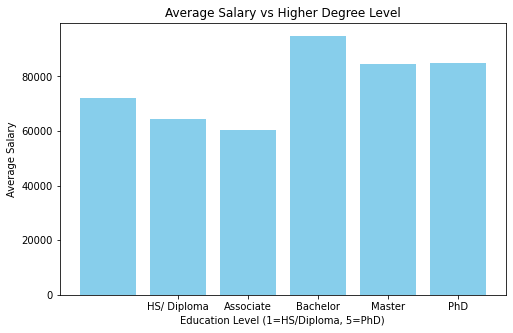

In [9]:
correlation = df.stat.corr("edu_level", "avg_salary")
print(f"Pearson correlation between higher degree and salary: {correlation:.3f}")

edu_salary_df = df.groupBy("edu_level").agg(round(avg("avg_salary"),2).alias("avg_salary"))\
                   .orderBy("edu_level")
edu_salary_pd = edu_salary_df.toPandas()

plt.figure(figsize=(8,5))
plt.bar(edu_salary_pd['edu_level'], edu_salary_pd['avg_salary'], color='skyblue')
plt.xlabel("Education Level (1=HS/Diploma, 5=PhD)")
plt.ylabel("Average Salary")
plt.title("Average Salary vs Higher Degree Level")
plt.xticks([1,2,3,4,5], ["HS/ Diploma","Associate","Bachelor","Master","PhD"])
plt.show()

### Deployment & Trigger
**Deployment:** Git version control, cloud/on-prem Spark cluster, Python module in S3.  
**Trigger:** Client mode for development, cluster mode for production, schedule via cron/Airflow.